# Intro

Welcome to GrabNGoInfo! This tutorial will talk about how to do time series anomaly detection using Facebook (Meta) Prophet model in Python. Anomalies are also called outliers, and we will use these two terms interchangeably in this tutorial. After the tutorial, you will learn:

* How to train a time series model using Prophet?
* How to make predictions using a Prophet model?
* How to identify outliers using a Prophet time series forecast?

Let's get started!

# Step 0: Algorithm for Time Series Anomaly Detection

In step 0, let's talk about the algorithm for time series anomaly detection. At a high level, the outliers are detected based on the prediction interval of the time series. The implementation includes the following steps:

1. Build a time series forecasting model.
2. Make predictions on historical data using the time series forecasting model.
3. Compare the actual values with the prediction intervals. Outliers are defined as the data points with actual values outside of the prediction intervals.

# Step 1: Install and Import Libraries

In the first step, we will install and import libraries.

`yfinance` is the python package for pulling stock data from Yahoo Finance. `prophet` is the package for the time series model. After installing `yfinance` and `prophet`, they are imported into the notebook.

We also import `pandas` and `numpy` for data processing, `seaborn` and `matplotlib` for visualization, and `mean_absolute_error` and `mean_absolute_percentage_error` for the model performance evaluation.

In [ ]:
# Install libraries
!pip install yfinance prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/





     |████████████████████████████████| 65 kB 2.4 MB/s 




     |████████████████████████████████| 63 kB 560 kB/s 





     |████████████████████████████████| 6.4 MB 51.2 MB/s 











     |████████████████████████████████| 49 kB 5.0 MB/s 










     |████████████████████████████████| 45 kB 3.1 MB/s 











  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641442 sha256=d8053b01fd0f2db0deb72a7b46df4fea176c40f7c7156d16cdd26a6953a31ab6

  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67

Successfully built prophet


  Attempting uninstall: requests

    Found existing installation: requests 2.23.0

    Uninstalling requests-2.23.0:

      Successfully uninstalled requests-2.23.0

  Attempting uninstall: lxml

    Found existing installation: lxml 4.2.6

    Uninstalling lxml-4.2.6:

      Suc

In [ ]:
# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Step 2: Pull Data

The second step pulls stock data from Yahoo Finance API. Two years of daily data from the beginning of 2020 to the end of 2021 are pulled for this analysis.

* `start_date = '2020-01-02'` because January 1st is a holiday, and there is no stock data on holidays and weekends.
* `end_date = '2022-01-01'` because `yfinance` excludes the end date, so we need to add one day to the last day of the data end date.


In [ ]:
# Data start date
start_date = '2020-01-02'

# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2022-01-01'

The goal of the time series model is to predict the closing price of Google's stock, so Google's ticker `GOOG` is used for pulling the data.

Prophet requires at least two columns as inputs: a `ds` column and a `y` column.
* The `ds` column has the time information. Currently we have the date as the index, so we reset the index and rename `date` to `ds`.
* The y column has the time series values. In this example, because we are predicting Google's closing price, the column name for the price is changed to `y`.

In [ ]:
# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Change column names
data = data.reset_index()
data.columns = ['ds', 'y']

# Remove timezone from timestamp - this code was added after yfiance package update on date format
data['ds'] = data['ds'].dt.tz_convert(None)

# Take a look at the data
data.head()

[*********************100%***********************]  1 of 1 completed


,ds,y
0,2020-01-02,1367.369995
1,2020-01-03,1360.660034
2,2020-01-06,1394.209961
3,2020-01-07,1393.339966
4,2020-01-08,1404.319946


Using `.info`, we can see that the dataset has 505 records and there are no missing values.

In [ ]:
# Information on the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 505 entries, 0 to 504

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype         

---  ------  --------------  -----         

 0   ds      505 non-null    datetime64[ns]

 1   y       505 non-null    float64       

dtypes: datetime64[ns](1), float64(1)

memory usage: 8.0 KB


Next, let's visualize the closing prices of the two tickers using `seaborn`, and add the legend to the plot using `matplotlib`. We can see that the price for Google increased a lot starting in late 2020, and almost doubled in late 2021.

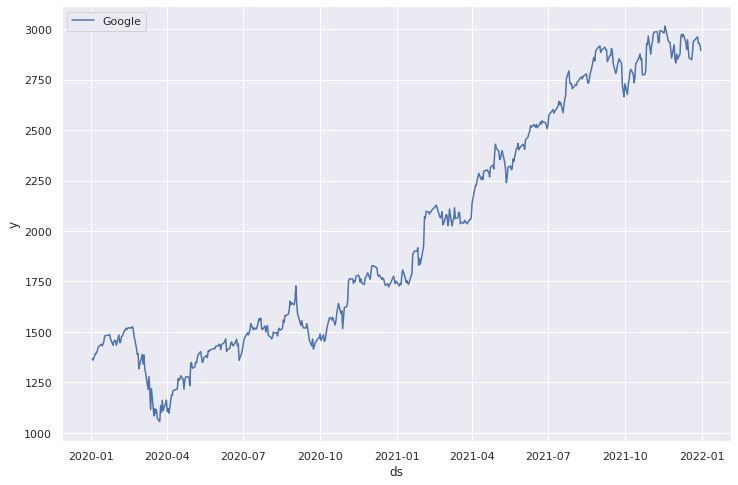

In [ ]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data['ds'], y=data['y'])
plt.legend(['Google'])

# Step 3: Build Time Series Model Using Prophet in Python

In step 3, we will build a time series model using Prophet in Python.

Notice that we did not do train test split for the modeling dataset. This is because the goal of the model is not to predict future stock prices, instead, the goal is to fit a model that predicts well on the past prices. Therefore, we will use the whole dataset for both training and forecasting.

* When initiating the prophet model, the `yearly_seasonality` and `weekly_seasonality` are explicitly set to True, and then fit on the training data.
* The `interval_width` is set to 0.99, which means that the uncertainty interval is 99%.

We keep the model simple in this example to focus on the process of anomaly detection. If you are interested in building a sophisticated model, please refer to my previous tutorial [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/grabngoinfo/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57)

In [ ]:
# Add seasonality
model = Prophet(interval_width=0.99, yearly_seasonality=True, weekly_seasonality=True)

# Fit the model on the training dataset
model.fit(data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Step 4: Make Predictions Using Prophet in Python

After building the model, in step 4, we use the model to make predictions on the dataset. The forecast plot shows that the predictions are in general aligned with the actual values.

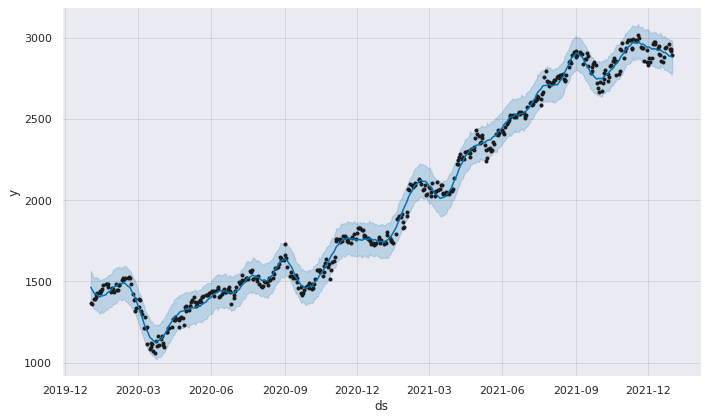

In [ ]:
# Make prediction
forecast = model.predict(data)

# Visualize the forecast
model.plot(forecast); # Add semi-colon to remove the duplicated chart

We can also check the components plot for the trend, weekly seasonality, and yearly seasonality.

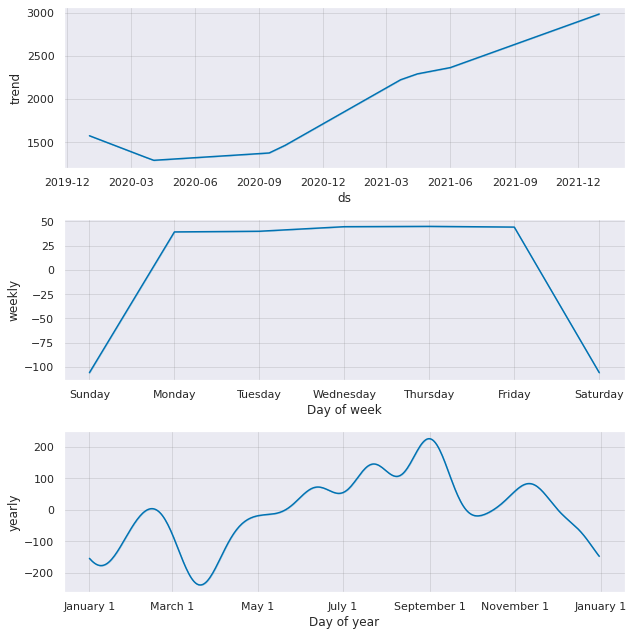

In [ ]:
# Visualize the forecast components
model.plot_components(forecast);

# Step 5: Check Time Series Model Performace

In step 5, we will check the time series model performance. The forecast dataframe does not include the actual values, so we need to merge the forecast dataframe with the actual dataframe to compare the actual values with the predicted values. Two performance metrics are included:

* MAE (Mean Absolute Error) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
* MAPE (Mean Absolute Percentage Error) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it’s undefined when the actual value is zero.

For more time series performance evaluation metrics such as MSE (Mean Squared Error), RMSE (Root Mean Square Error), MDAPE (Median Absolute Percentage Error), and SMAPE (Symmetric Mean Absolute Percentage Error), please refer to my previous tutorial [Time Series Forecasting Of Bitcoin Prices Using Prophet](https://medium.com/grabngoinfo/time-series-forecasting-of-bitcoin-prices-using-prophet-1069133708bc)

In [ ]:
# Merge actual and predicted values
performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Check MAE value
performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE for the model is {performance_MAE}')

# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'The MAPE for the model is {performance_MAPE}')

The MAE for the model is 31.490791238759932

The MAPE for the model is 0.01699185966792339


The mean absolute error (MAE) for the model is \$31, meaning that on average, the forecast is off by \$31. Given that Google's price is in thousands, the prediction is not bad.

The mean absolute percent error (MAPE) for the baseline model is 1.7%, meaning that on average, the forecast is off by 1.7% of the stock price.

# Step 6: Identify Anomalies

In step 6, we will identify the time series anomalies by checking if the actual value is outside of the uncertainty interval. If the actual value is smaller than the lower bound or larger than the upper bound of the uncertainty interval, the anomaly indicator is set to 1, otherwise, it's set to 0.

Using `value_counts()`, we can see that there are 6 outliers out of 505 data points.

In [ ]:
# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

# Check the number of anomalies
performance['anomaly'].value_counts()

0    499
1      6
Name: anomaly, dtype: int64

After printing out the anomalies, we can see that all the outliers are lower than the lower bound of the uncertainty interval.

In [ ]:
# Take a look at the anomalies
anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
anomalies

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
0,2020-01-02,1367.369995,1463.980957,1370.797971,1565.641265,1
208,2020-10-28,1516.619995,1644.967178,1549.907088,1744.473281,1
271,2021-01-29,1835.739990,1955.949937,1857.329816,2053.675205,1
342,2021-05-12,2239.080078,2364.704057,2268.392407,2458.705776,1
343,2021-05-13,2261.969971,2367.267942,2264.777802,2479.921623,1
483,2021-12-01,2832.360107,2944.239736,2841.949288,3050.945373,1


In the visualization, all the dots are actual values and the black line represents the predicted values. The orange dots are the outliers.

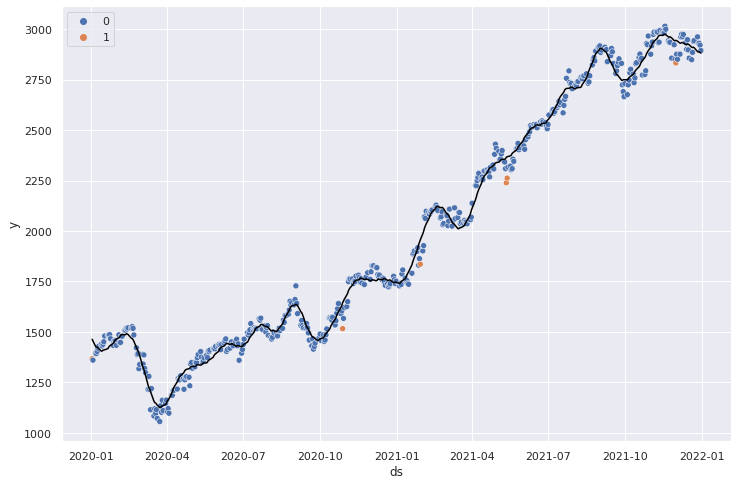

In [ ]:
# Visualize the anomalies
sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=performance, color='black')

# Put All Code Together

In [ ]:
#-------------------------------------------------------------------------#
# Step 1: Install and Import Libraries
#-------------------------------------------------------------------------#

# Install libraries
!pip install yfinance prophet

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

#-------------------------------------------------------------------------#
# Step 2: Pull Data
#-------------------------------------------------------------------------#

# Data start date
start_date = '2020-01-02'

# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2022-01-01'

# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Change column names
data = data.reset_index()
data.columns = ['ds', 'y']

# Take a look at the data
data.head()

# Information on the dataframe
data.info()

# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data['ds'], y=data['y'])
plt.legend(['Google'])

#-------------------------------------------------------------------------#
# Step 3: Build Time Series Model Using Prophet in Python
#-------------------------------------------------------------------------#

# Add seasonality
model = Prophet(interval_width=0.99, yearly_seasonality=True, weekly_seasonality=True)

# Fit the model on the training dataset
model.fit(data)

#-------------------------------------------------------------------------#
# Step 4: Make Predictions Using Prophet in Python
#-------------------------------------------------------------------------#

# Make prediction
forecast = model.predict(data)

# Visualize the forecast
model.plot(forecast); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model.plot_components(forecast);

#-------------------------------------------------------------------------#
# Step 5: Check Time Series Model Performace
#-------------------------------------------------------------------------#

# Merge actual and predicted values
performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Check MAE value
performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE for the model is {performance_MAE}')

# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'The MAPE for the model is {performance_MAPE}')

#-------------------------------------------------------------------------#
# Step 6: Identify Anomalies
#-------------------------------------------------------------------------#

# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

# Check the number of anomalies
performance['anomaly'].value_counts()

# Take a look at the anomalies
anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
anomalies

# Visualize the anomalies
sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=performance, color='black')
